In [3]:
!pip install altair vega_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics as smgraphics
import altair as alt

     |████████████████████████████████| 727 kB 2.4 MB/s 
     |████████████████████████████████| 210 kB 14.0 MB/s 


# Data from workpackage D3.2 loaded into Dataframe
The data that we load are from the lab-made samples, i.e. we exclude for now the real brine samples from Romania. We will us those sample later on for comparison.

In [7]:
df=pd.read_pickle('Data/dfLab.pickle')
#df=pd.read_csv('dfAll.csv',index_col=0)

#make columnnames less human friendly and more computer friendly
df.columns = df.columns.str.strip()\
                           .str.lower()\
                           .str.replace('+','')\
                           .str.replace('^','')\
                           .str.replace(' ', '_')\
                           .str.replace('[', '')\
                           .str.replace(']', '')\
                           .str.replace('/', '')\
                           .str.replace('_mgl','')

df.columns = df.columns.str.replace('salinity_gl','s')\
                         .str.replace('temperature','t')

In [8]:
df.head()

,ph,t,brine_origin,energy_input_kwhm3,ca,mg,s,fe,al,li,cu,energy_input_kwhkg_metal_rem.,ewe,ca__mg,al_outin_ratio,li_outin_ratio
0,3,20,ICELAND,0.19,1750,5,30,0.0,180.0,0,0.0,2.10,0.35,1755,NaN,NaN
1,3,50,ICELAND,0.09,1750,5,30,0.0,180.0,0,0.0,5.17,0.35,1755,NaN,NaN
2,3,20,BELGIUM,2.10,10000,600,30,50.0,0.0,0,15.0,3.40,0.35,10600,NaN,NaN
3,3,50,BELGIUM,1.96,10000,600,30,50.0,0.0,0,15.0,11.50,0.35,10600,NaN,NaN
4,3,20,ENGLAND,0.96,1000,50,30,800.0,0.0,0,0.0,11.40,0.35,1050,NaN,NaN


# Correlation matrix for selected set of variables
Below we see the correlation matrix between diffrent parameters. If we focus on the energy input per kg of metal removed we see that it correlates poorly with most parameters except the magnesium content.

In [9]:
smalldf=df[['energy_input_kwhkg_metal_rem.','mg','ca','li','al','t','s','ewe']].copy()
smalldf.corr().style.background_gradient().set_precision(2)

,energy_input_kwhkg_metal_rem.,mg,ca,li,al,t,s,ewe
energy_input_kwhkg_metal_rem.,1.00,0.85,-0.01,0.04,0.01,-0.10,-0.15,0.14
mg,0.85,1.00,0.13,-0.02,-0.20,0.00,-0.08,-0.11
ca,-0.01,0.13,1.00,-0.13,-0.30,0.08,-0.08,-0.10
li,0.04,-0.02,-0.13,1.00,0.34,-0.26,0.07,0.10
al,0.01,-0.20,-0.30,0.34,1.00,-0.33,0.03,0.03
t,-0.10,0.00,0.08,-0.26,-0.33,1.00,-0.06,-0.08
s,-0.15,-0.08,-0.08,0.07,0.03,-0.06,1.00,-0.06
ewe,0.14,-0.11,-0.10,0.10,0.03,-0.08,-0.06,1.00


# Linear regression model for predicting the energy input
Here we use the data from the lab samples to make a linear regression model for the energy input as a function of Mg,Ca,Salinity, Ewe and temperture. We want the output data to be restricted to the interval $]0, \infty]$, so we fit the data in log-space.

In [10]:
#Features selected for the regression model
X=df[['mg','ca','ph','s','t','ewe']]
X=X.fillna(0)
X=sm.add_constant(X)

#Labels selected for the regression model
Y=np.log(df['energy_input_kwhkg_metal_rem.'])

#The model fitted
est=sm.OLS(Y,X)
est=est.fit()
est.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     energy_input_kwhkg_metal_rem.   R-squared:                       0.621
Model:                                       OLS   Adj. R-squared:                  0.587
Method:                            Least Squares   F-statistic:                     18.53
Date:                           Tue, 06 Oct 2020   Prob (F-statistic):           1.23e-12
Time:                                   03:03:57   Log-Likelihood:                -40.251
No. Observations:                             75   AIC:                             94.50
Df Residuals:                                 68   BIC:                             110.7
Df Model:                                      6                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3529      0.354      3.820      0.000       0.646       2.060
mg             0.0016      0.000      9.010      0.000       0.001       0.002
ca         -8.196e-06   1.57e-05     -0.521      0.604   -3.96e-05    2.32e-05
ph             0.0756      0.024      3.152      0.002       0.028       0.123
s             -0.0050      0.002     -2.246      0.028      -0.009      -0.001
t             -0.0001      0.007     -0.018      0.986      -0.013       0.013
ewe            1.7076      0.407      4.194      0.000       0.895       2.520
==============================================================================
Omnibus:                       16.952   Durbin-Watson:                   1.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.596
Skew:                          -0.388   Prob(JB):                     3.46e-15
Kurtosis:                       7.551   Cond. No.                     3.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

# Small code to automatically write the python directly from the linear regression results

In [11]:
import string

print("def eOut0(P):")
ret="    return np.exp("
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"="+str(est.params[y])+"    #"+y)
    if y=='const':
        ret=ret+x+"+"   
    else:   
        ret=ret+x+"*P['"+y+"']+"
print(ret[:-1]+")")
        
print("def eOut(P):")
for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
    print("    "+x+"=np.random.normal("+str(est.params[y])+","+str(est.bse[y])+")    #"+y)

print(ret[:-1]+")")

def eOut0(P):
    A=1.3529312060941705    #const
    B=0.0016362141049857779    #mg
    C=-8.196073337778315e-06    #ca
    D=0.07557845354792624    #ph
    E=-0.004987188886452974    #s
    F=-0.00011957753143073888    #t
    G=1.707625895831621    #ewe
    return np.exp(A+B*P[&#39;mg&#39;]+C*P[&#39;ca&#39;]+D*P[&#39;ph&#39;]+E*P[&#39;s&#39;]+F*P[&#39;t&#39;]+G*P[&#39;ewe&#39;])
def eOut(P):
    A=np.random.normal(1.3529312060941705,0.3542152342034814)    #const
    B=np.random.normal(0.0016362141049857779,0.00018160702545665994)    #mg
    C=np.random.normal(-8.196073337778315e-06,1.5739463852203673e-05)    #ca
    D=np.random.normal(0.07557845354792624,0.02397543467409866)    #ph
    E=np.random.normal(-0.004987188886452974,0.002220960422963054)    #s
    F=np.random.normal(-0.00011957753143073888,0.006561245183509722)    #t
    G=np.random.normal(1.707625895831621,0.40714694288472075)    #ewe
    return np.exp(A+B*P[&#39;mg&#39;]+C*P[&#39;ca&#39;]+D*P[&#39;ph&#39;]+E*P[&#39;s&#39;]

# Code for the linear regression model for the GEDx component 
Just copy pasted from the output of the cell above. The first function calculates energy intput values directly from the mean values of parameters from the regression analysis.
The second function calculates energy input values from randomly selected parameters. The probability distribution for the parameters are also from the regression analysis above.

In [12]:
def eOut0(P):
    A=1.3529312060941696    #const
    B=0.0016362141049857614    #mg
    C=-8.196073337778003e-06    #ca
    D=0.07557845354792614    #ph
    E=-0.004987188886452918    #s
    F=-0.00011957753143076837    #t
    G=1.707625895831622    #ewe
    return np.exp(A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe'])
def eOut(P):
    A=np.random.normal(1.3529312060941696,0.3542152342034814)    #const
    B=np.random.normal(0.0016362141049857614,0.0001816070254566602)    #mg
    C=np.random.normal(-8.196073337778003e-06,1.5739463852203646e-05)    #ca
    D=np.random.normal(0.07557845354792614,0.023975434674098652)    #ph
    E=np.random.normal(-0.004987188886452918,0.002220960422963053)    #s
    F=np.random.normal(-0.00011957753143076837,0.0065612451835097224)    #t
    G=np.random.normal(1.707625895831622,0.40714694288472075)    #ewe
    return np.exp(A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']+F*P['t']+G*P['ewe'])

# Prediction of energy input calculated using the model 
Here we load in all the available data, including the brine data from Romania

In [15]:
dfAll=pd.read_pickle('Data/dfAll.pickle')
dfAll.columns = dfAll.columns.str.strip()\
                     .str.lower()\
                     .str.replace('+','')\
                     .str.replace('^','')\
                     .str.replace(' ', '_')\
                     .str.replace('[', '')\
                     .str.replace(']', '')\
                     .str.replace('/', '')\
                     .str.replace('_mgl','')
dfAll.columns = dfAll.columns.str.replace('salinity_gl','s')\
                             .str.replace('temperature','t')
dfAll['brine_origin']=dfAll['brine_origin'].fillna('LAB')

The model values, upper and lower standard deviation bounds and model error calculated

In [16]:
dfAll['energy_input_model']=dfAll.apply(lambda row: eOut0(row), axis=1)

dfAll[['e2p3','e15p9','e84p1','e97p7']]=dfAll.apply(lambda row: pd.Series(np.round(np.percentile([eOut(row) for i in range(1000)],[2.3,15.9,84.1,97.7]),1)),axis=1)

dfAll['model Error']=dfAll['energy_input_kwhkg_metal_rem.']-dfAll['energy_input_model']

Plotting the comparison of the model to the measurements. Note that the Romanian samples where not included in the fit. Including them increases the errorbars substantially. 

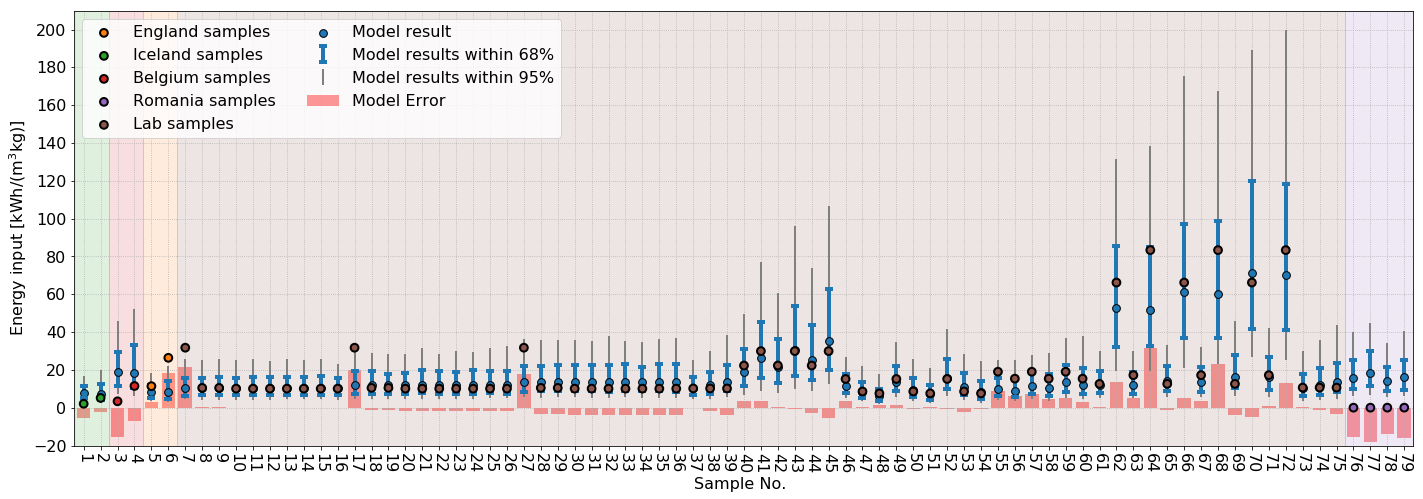

In [17]:
plt.rcParams.update({'font.size': 16})
colors = {'ENGLAND':'C1', 'ICELAND':'C2', 'BELGIUM':'C3', 'ROMANIA':'C4','LAB':'C5'}
fig,ax=plt.subplots(figsize=(24,8))

#-------plotting the 68 % error bars------------------------------------------------
ax.errorbar(dfAll['energy_input_model'].index+1,
            dfAll['energy_input_model'].values,
            yerr=np.vstack([dfAll['energy_input_model'].values-dfAll['e15p9'].values,
                            dfAll['e84p1'].values-dfAll['energy_input_model'].values]),
            capsize=4,
            capthick=4,
            linewidth=4,
            fmt ='none',
            zorder=20,
            label='Model results within 68%')

#-------plotting the 95 % error bars------------------------------------------------
ax.errorbar(dfAll['energy_input_model'].index+1,
            dfAll['energy_input_model'].values,
            yerr=np.vstack([dfAll['energy_input_model'].values-dfAll['e2p3'].values,
                            dfAll['e97p7'].values-dfAll['energy_input_model'].values]),
            capsize=0,
            capthick=1,
            linewidth=2,
            color='grey',
            fmt ='none',
            zorder=10,
            label='Model results within 95%')

#-------plotting the measured samples and coloring the background to indicate sample origin----------------------
for origin in ['ENGLAND','ICELAND','BELGIUM','ROMANIA','LAB']:
    subdf=dfAll[dfAll['brine_origin']==origin]
    ax.scatter(subdf.index+1, subdf['energy_input_kwhkg_metal_rem.'], color=subdf['brine_origin'].apply(lambda x: colors[x]),s=60,edgecolor='k',lw=2,zorder=30,label=origin.title()+" samples")
    plt.axvspan(subdf.index[0]+1-0.5,subdf.index[-1]+1+0.5, color=colors[origin],alpha=0.15)
    
#-------plotting the model result----------------------------------------------------
ax.scatter(dfAll.index+1,dfAll['energy_input_model'],color='C0',s=60,edgecolor='k',zorder=20,label='Model result')

#-------plotting the model error----------------------------------------------------
ax.bar(dfAll.index+1,dfAll['model Error'],color='red',alpha=0.4,zorder=0,label='Model Error')


#------tweaking the look of the plot------------------------------------------------
ax.set_xticks(range(len(dfAll)+1))
ax.set_ylim(-20,210)
ax.set_xlim(0.4,79.5)
ax.set_yticks(range(-20,210,20))
ax.set_ylabel("Energy input [kWh/(m$^3$kg)]")
ax.set_xlabel("Sample No. ")
plt.xticks(rotation=-90)
ax.grid(linestyle='dotted')
ax.legend(ncol=2,loc=2)
plt.savefig("GEDx_Energy_Model.png", bbox_inches='tight')

Histograms of the energy distrubtions created by the model compared for each sample

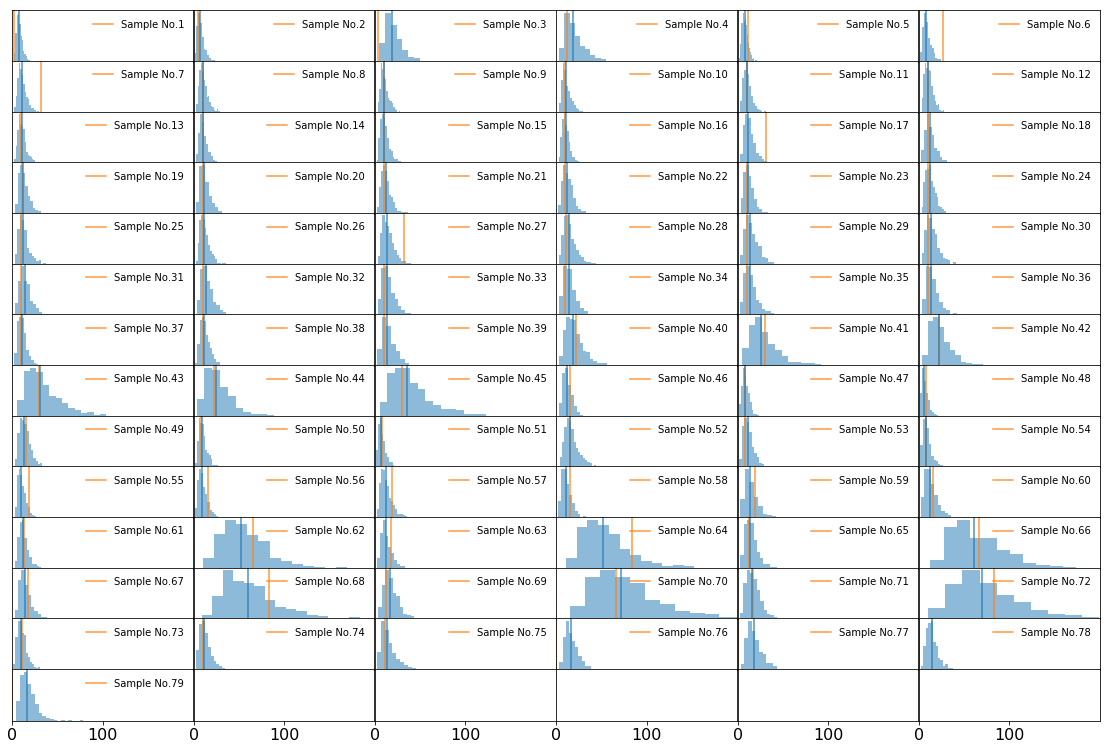

In [18]:
fig,ax=plt.subplots(14,6,figsize=(15,10),sharex=True)
for n in range(79):
    ax[n//6][n%6].hist([eOut(dfAll.iloc[n]) for i in range(1000)],20,label=None,alpha=0.5);
    ax[n//6][n%6].axvline(dfAll['energy_input_kwhkg_metal_rem.'].iloc[n],color='C1',label='Sample No.'+str(n+1),alpha=0.8);
    ax[n//6][n%6].axvline(dfAll['energy_input_model'].iloc[n],color='C0',label=None,alpha=0.8);
    ax[n//6][n%6].legend(fontsize=10,frameon=False)
    
for n in range(14*6):
    ax[n//6][n%6].set_yticks([])
    ax[n//6][n%6].set_xlim(0,200)
    ax[n//6][n%6].set_xticks([0,100])

plt.tight_layout(pad=-0.5)
plt.savefig("GEDx_Energy_Model_histograms.png", bbox_inches='tight')